## Interpolate the gap between the two SWOT swaths using the KaRIn and Nadir data

In [1]:
import netCDF4 as nc
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist 
import mpmath as mp
import cartopy.crs as ccrs
from math import sin, cos, sqrt, atan2, radians
import os
import cmocean 
from glob import glob
import numpy as np
import time
import mpmath as mp
from scipy.special import gamma
import matplotlib.pyplot as plt

# This is our toolbox 
import JWS_SWOT_toolbox as swot

%load_ext autoreload
%autoreload 2

### 1. Import the KaRIn and Nadir data, match the data files, and build the datasets 

Search through the data directory and import files for KaRIn and Nadir with same cycles and specified pass number

In [37]:
# Config. parameters
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/'

min_cycle = 476
max_cycle = 580

pass_number = 4
lat_min = 26
lat_max = 32

# return the files in the data directory for the specified pass number
# karin_files, nadir_files are sorted by cycle and contain the same cycles
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_number)

# Returns indexes for the Karin and Nadir data between lat_min and lat_max 
indx, track_length = swot.get_karin_track_indices(karin_files[10][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[10][0], lat_min, lat_max)
dims = [len(shared_cycles), track_length, track_length_nadir]

In [ ]:
# Init the data classes -- (time, along_track, across_track)
karin, nadir = swot.init_swot_arrays(dims)

# Load and process Karin data
swot.load_karin_data(karin_files, indx, karin)
swot.process_karin_data(karin)

# Load and process Nadir data
swot.load_nadir_data(nadir_files, indxs, nadir)
swot.process_nadir_data(nadir)

# compute the dx, dy, dy_nadir of the grids -- in [m]
karin.distances()
nadir.distances()

# Builds the coordinate grids -- in [m]
karin.coordinates()
nadir.coordinates()

### 2. Compute the power spectra 

In [39]:
# --- windows and grids ---
karin.window = xr.DataArray(swot.sin2_window_func(karin.track_length), dims=['line'])
nadir.window = xr.DataArray(swot.sin2_window_func(nadir.track_length), dims=['nadir_line'])
k_coords     = [karin.y_coord, karin.x_coord]
kt_coords    = [karin.t_coord, karin.y_coord, karin.x_coord]
n_coords     = [nadir.y_coord]
nt_coords    = [nadir.t_coord, nadir.y_coord]

# --- xarrays ---
# KaRIn
karin_mean           = xr.DataArray(karin.ssh_mean, coords = k_coords, dims = ['line', 'pixel'])
karin_mean_filtered  = xr.DataArray(karin.ssha_mean_highpass, coords = k_coords, dims = ['line', 'pixel'])
karin_ssh            = xr.DataArray(karin.ssh, coords = kt_coords, dims = ['sample', 'line', 'pixel']) # full ssh
karin_ssha           = xr.DataArray(karin.ssha, coords = kt_coords, dims = ['sample', 'line', 'pixel']) # ssh with time mean removed 
# Nadir
nadir_ssh            = xr.DataArray(nadir.ssh, coords = nt_coords, dims=['sample', 'nadir_line'])

# --- remove spatial mean ---
karin_spatial_mean = swot.spatial_mean(karin_ssha, ['line', 'pixel'])
karin_anomsp       = karin_ssha - karin_spatial_mean
nadir_spatial_mean = swot.spatial_mean(nadir_ssh, ['nadir_line'])
nadir_anomsp       = nadir_ssh - nadir_spatial_mean

# --- spectral analysis ---
# Karin spectra 
karin.spec_ssh          = swot.mean_power_spectrum(karin_ssh, karin.window, 'line', ['sample', 'pixel'])
karin.spec_tmean        = swot.mean_power_spectrum(karin_mean, karin.window, 'line', ['pixel'])
karin.spec_filt_tmean   = swot.mean_power_spectrum(karin_mean_filtered, karin.window, 'line', ['pixel'])
karin.spec_ssha         = swot.mean_power_spectrum(karin_ssha, karin.window, 'line', ['sample', 'pixel'])
karin.spec_alongtrack_av  = swot.mean_power_spectrum(karin_anomsp, karin.window, 'line', ['sample', 'pixel']) # Full mean spectrum
karin.spec_alongtrack_ins = swot.mean_power_spectrum(karin_anomsp, karin.window, 'line', ['pixel']) # spec at each sample
karin.wavenumbers         = karin.spec_alongtrack_ins.freq_line 

# Nadir spectra
nadir.spec_ssh            = swot.mean_power_spectrum(nadir_ssh, nadir.window, 'nadir_line', ['sample'])
nadir.spec_alongtrack_av  = swot.mean_power_spectrum(nadir_anomsp, nadir.window, 'nadir_line', ['sample'])
nadir.spec_alongtrack_ins = swot.mean_power_spectrum(nadir_anomsp, nadir.window, 'nadir_line', []) # spec at each sample
nadir.wavenumbers         = nadir.spec_alongtrack_ins.freq_nadir_line
# # Tides
# karin_tide             = xr.DataArray(tide_karin, coords=[samples, y_karin, x_karin], dims=['sample', 'line', 'pixel'])
# spec_karin_tide        = swot.mean_power_spectrum(karin_tide, window_karin, 'line', ['sample', 'pixel'])

# --- Parseval's theorem check ---
print("KaRIn Spectrum")
_ = swot.parseval_check(
    karin_anomsp.values[1, :, :],  # Pick one sample, all lines and pixels
    karin.spec_alongtrack_ins[10],
    karin.dx,
    freq_dim='freq_line'
)
print("Nadir Spectrum")
# Check for Nadir: along-track, average spectrum
_ = swot.parseval_check(
    nadir_anomsp.values[1, :],  # Pick one sample, all nadir lines
    nadir.spec_alongtrack_ins[10],
    nadir.dy,
    freq_dim='freq_nadir_line'  # or 'freq_nadir_line' if your spectrum uses a different name
)

KaRIn Spectrum
Parseval check: var_space = 0.0051569, var_spec = 0.011507, rel_error = 1.23
Nadir Spectrum
Parseval check: var_space = 0.0069565, var_spec = 0.011559, rel_error = 0.662


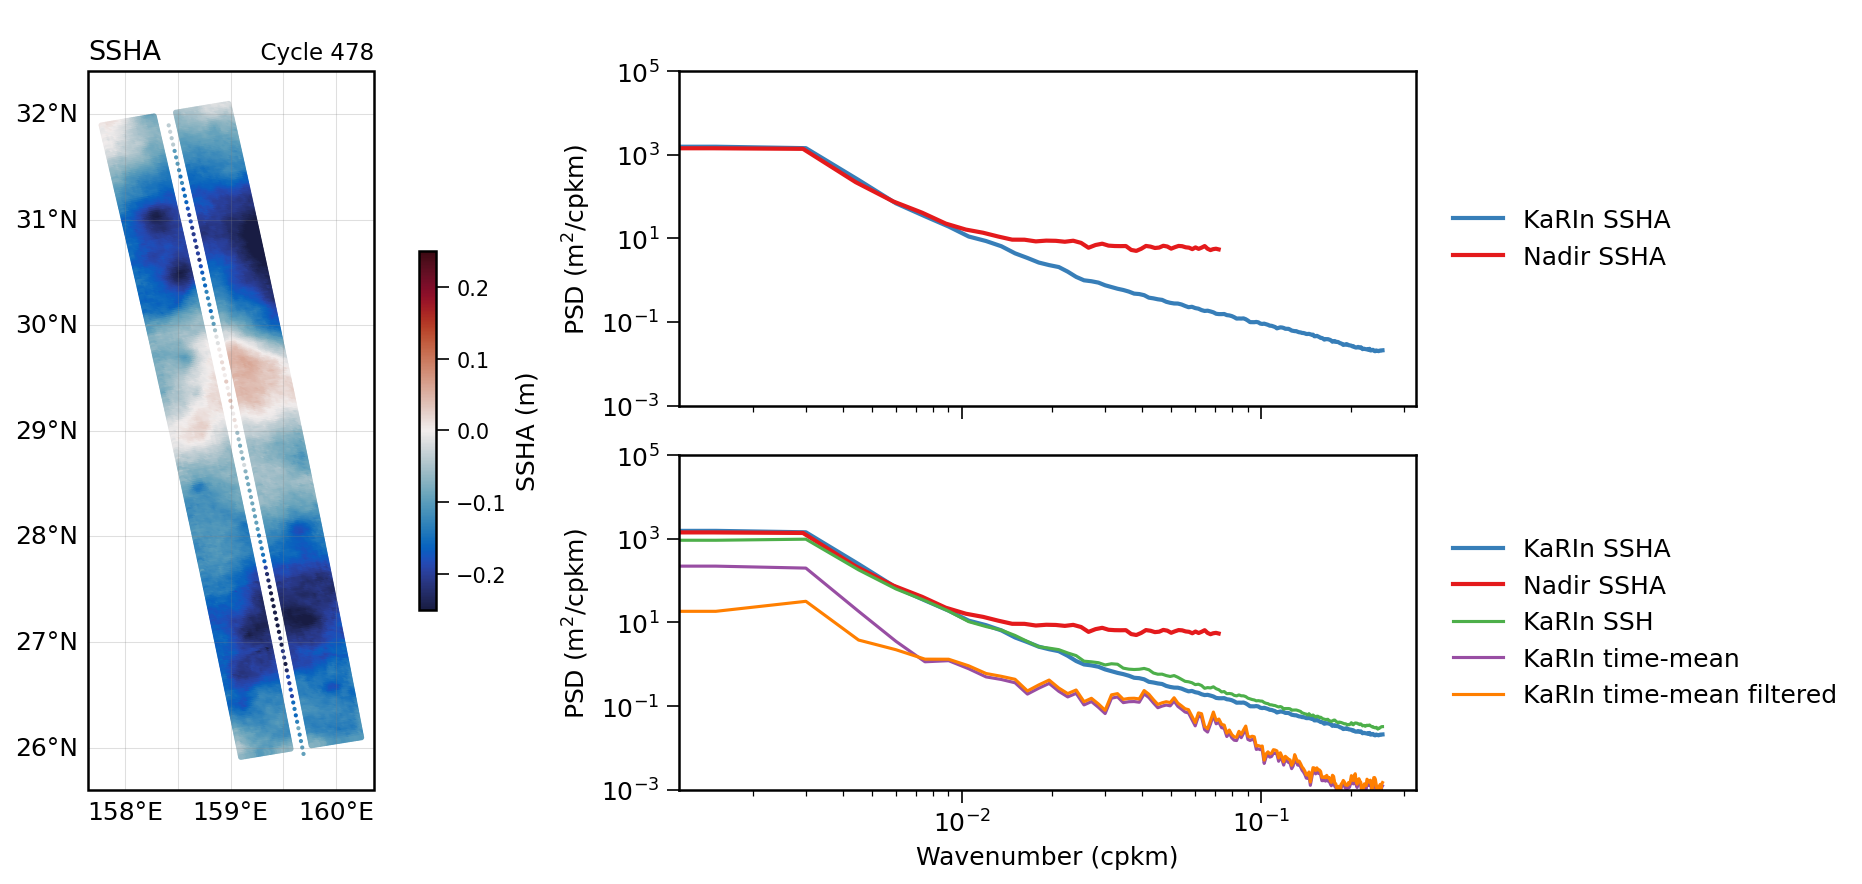

In [42]:
# Plot the fields and spectra 
index = 1
vmax = 0.25
vmin = -0.25
ylims = (1e-3, 1e5)

swot.set_plot_style()

fig = plt.figure(figsize=(14, 6), dpi=150)

# -------- Map --------
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
cmap = cmocean.cm.balance
sc = ax1.scatter(karin.lon[index, :, :], karin.lat[index, :, :], c=karin.ssha[index, :, :], s=3, vmin=vmin, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree(), marker='o')
ax1.scatter(nadir.lon[index, :], nadir.lat[index, :], c=nadir.ssh[index, :].flatten(), vmin=vmin, vmax=vmax, cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree())
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25, color='gray', linestyle='-', xlabel_style={'size': 12}, ylabel_style={'size': 12})
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True 
gl.bottom_labels = True 
ax1.set_title(f'SSHA', loc='left')
ax1.set_title(f'\n  Cycle {shared_cycles[index]}', loc='right', fontsize=11)
cbar = fig.colorbar(sc, ax=ax1, orientation='vertical', shrink=0.5, pad=0.06)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('SSHA (m)')

# -------- Power Spectra --------
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, figure=fig)
ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(karin.wavenumbers*1e3, karin.spec_alongtrack_av, label='KaRIn SSHA', linewidth=2)
ax2.loglog(nadir.wavenumbers*1e3, nadir.spec_alongtrack_av, label='Nadir SSHA', linewidth=2)
ax2.set_ylabel('PSD (m$^2$/cpkm)')
#ax2.set_title('Power Spectra')
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
ax2.tick_params(axis='x', which='both', labelbottom=False)
ax2.set_ylim(ylims)
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_alongtrack_av, label='KaRIn SSHA', linewidth=2)
ax3.loglog(nadir.wavenumbers*1e3, nadir.spec_alongtrack_av, label='Nadir SSHA', linewidth=2)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_ssh, label='KaRIn SSH', linewidth=1.5)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_tmean, label='KaRIn time-mean', linewidth=1.5)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_filt_tmean, label='KaRIn time-mean filtered', linewidth=1.5)
# ax3.loglog(spec_karin_tide.freq_line*1e3, spec_karin_tide, label='Tide', linewidth=1.5)
# # ax3.loglog(spec_nadir_mean.freq_nadir_line*1e3, spec_nadir_mean, label='Nadir time-mean', linewidth=1.5)
# ax3.loglog(spec_nadir_mean.freq_nadir_line*1e3, spec_nadir_mean_filtered, label='Nadir time-mean filtered', linewidth=1.5)
ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('PSD (m$^2$/cpkm)')
ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
#ax3.grid(True, which='both', linestyle=':', linewidth=0.5)
ax3.set_ylim(ylims)
plt.tight_layout()
plt.show()


### 3. Extract the balanced signal

We now extract the balanced and unbalanced signals in the KaRIn and Nadir data by fitting models to their spectra.

The balanced part of the KarIn spectrum is fitted with

# $\frac{A_b}{(1 + (\lambda_b  k)^{s_b})}$

and the unbalanced part is fitted to the model: 

# $\frac{A_n}{(1 + (\lambda_n  k)^2)^{s_n/2}}$

Where $\lambda_n = 100$ km is fixed in the function due to the poor constraint on this parameter

Note that there is also the option to fit to the Mattern model

## $\frac{2\pi\Gamma(\gamma+1/2)(2\gamma)^{\gamma}}{\Gamma(\gamma)\lambda^{2\gamma}}(\frac{2\gamma}{\lambda^{2}}+4\pi^{2}k^{2})^{-\gamma+1/2}$

### Model balanced and unbalanced signal from KaRIn

Text(0.5, 1.0, 'Weighted fit KaRIn data')

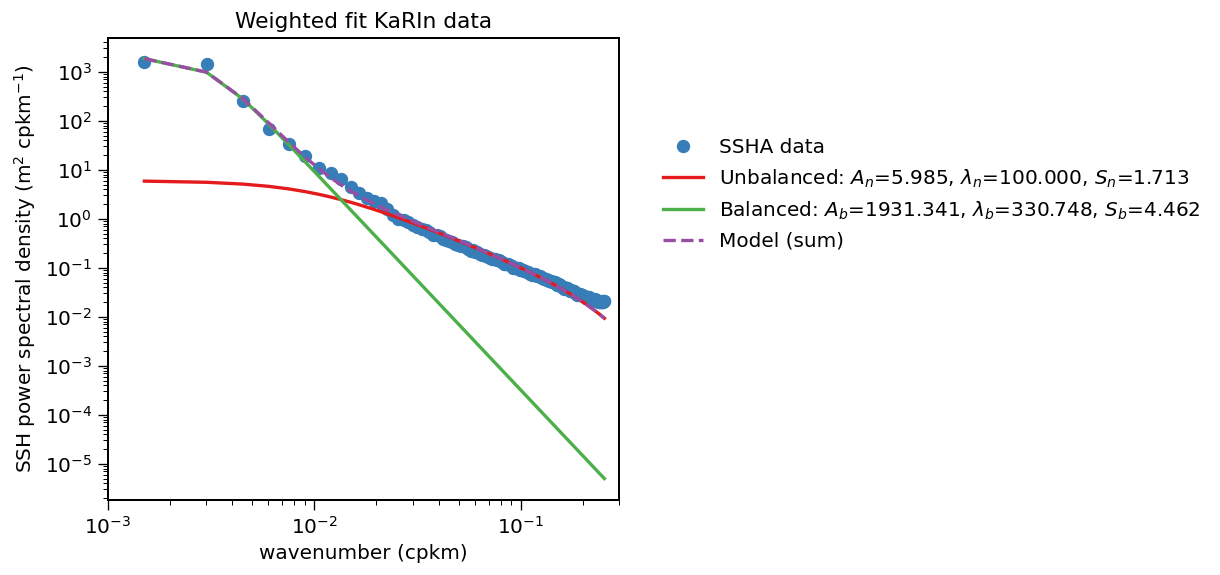

In [7]:
# use the positive half of the along track averaged spectrum for our model fits
k_karin = (karin.wavenumbers[int(karin.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean = karin.spec_alongtrack_av[int(karin.track_length/2):]

# fit the model to the data
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# plot the weighted fit
spbalanced = swot.balanced_model(k_karin[1:],*poptcwg_karin[0:3])
spunbalanced = swot.unbalanced_model(k_karin,*poptcwg_karin[3:7])
plt.figure(figsize=(5.5,5), dpi=120)
k_km = k_karin * 1e3 # wavenumbers in km for plotting
plt.loglog(k_km[1:], karin_spec_sample_mean[1:],'o', label = 'SSHA data')
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced: $A_n$=%5.3f, $\lambda_n$=%5.3f, $S_n$=%5.3f' % (poptcwg_karin[3], 100, poptcwg_karin[5]))
plt.loglog(k_km[1:], spbalanced,label = r'Balanced: $A_b$=%5.3f, $\lambda_b$=%5.3f, $S_b$=%5.3f' % (poptcwg_karin[0], poptcwg_karin[1]*1e-3, poptcwg_karin[2]))
plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
plt.xlim(1e-3, 3e-1)
plt.title('Weighted fit KaRIn data')


### Model balanced and unbalanced signal from Nadir

Fitted noise floor N = 6.775003683565389


Text(0.5, 1.0, 'Weighted fit nadir data')

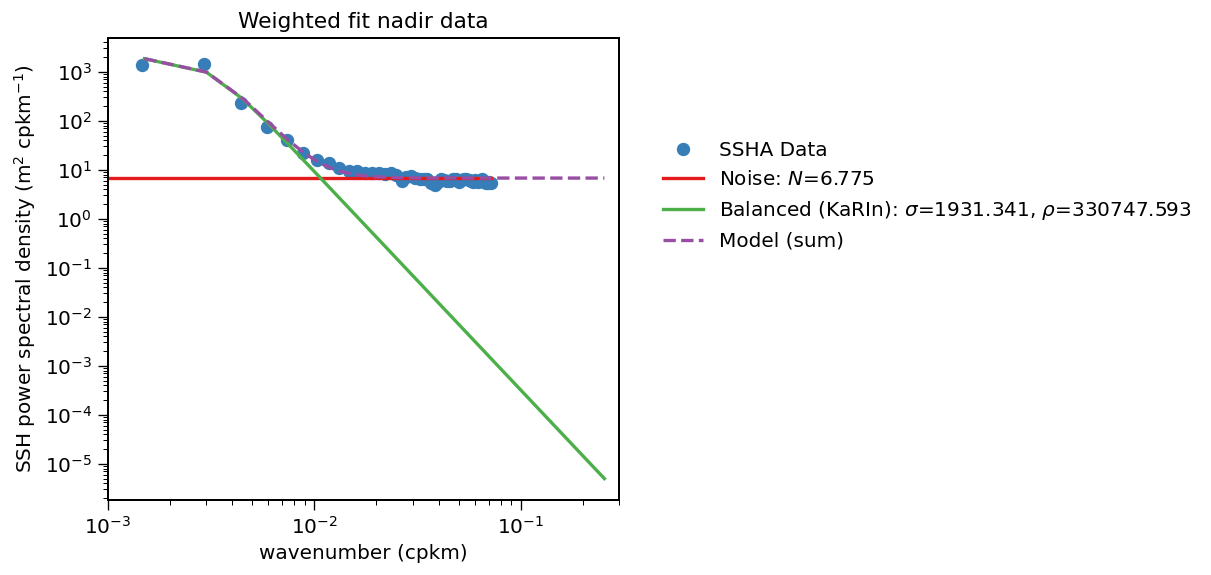

In [8]:
k_nadir = (nadir.wavenumbers[int(nadir.track_length/2):])# wavenumbers of the nadir data in units [1/m]
nadir_spec_sample_mean = nadir.spec_alongtrack_av[int(nadir.track_length/2):]

# Assume k_nadir, spec_nadir_sample_mean, track_length, poptcwg_karin already obtained from the KaRIn fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)
print("Fitted noise floor N =", poptcwg_nadir[0])

# plot the weighted fit
spnoise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])
plt.figure(figsize=(5.5,5), dpi=120)
plt.loglog(k_nadir[1:]*1e3, nadir_spec_sample_mean[1:],' o', label = 'SSHA Data')
plt.loglog(k_nadir*1e3, spnoise_nadir, label = r'Noise: $N$=%5.3f' % poptcwg_nadir[0])
plt.loglog(k_karin[1:]*1e3, spbalanced,'-', label = r'Balanced (KaRIn): $\sigma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[0:2]))
plt.loglog(k_karin[1:]*1e3, (spbalanced + spnoise_nadir[:1]), '--', label = 'Model (sum)')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
plt.xlim(1e-3, 3e-1)
# plt.ylim(1, 1e3)
plt.title('Weighted fit nadir data')

## 4. Generate Covariances 

We now generate covariance functions for our spectrum models to extract the balanced component and also interpolate the gap. 

First we will do a test reconstruction with a random signal and noise field which will have the same spectral characteristics as the SWOT spectra above.

In [9]:
# Parameters from spectral estimation above
A_b, lam_b, s_param = poptcwg_karin[0], poptcwg_karin[1], poptcwg_karin[2] # balanced params from fit
A_n, s_n, lam_n = poptcwg_karin[3], poptcwg_karin[5], 1e5 # unbalanced params from fit, we fixed lam_k to 100km in unbalanced model above
N_n = poptcwg_nadir[0] # Nadir noise

# Pull in our parameters
ny = 2*karin.swath_width
gap = karin.middle_width
delta_kx = karin.dx
delta_ky = karin.dy
delta_n = nadir.dy
nx = karin.track_length
nn = nadir.track_length 

# balanced
S = lambda k: A_b / (1 + (lam_b * k)**s_param)
c = swot.cov(S, 5000000, 10000e3)

# unbalanced
cutoff = 1e3
sigma = 2 * np.pi * cutoff/np.sqrt(2*np.log(2)) 
Sk = lambda k: A_n / (1 + (lam_n * k)**2)**(s_n / 2) * np.exp(-0.5 * ((sigma**2)*(k**2))) # add guassian taper to smallest scales
nk = swot.cov(Sk, 5000, 10000e3)
sigma = np.sqrt(N_n / (2 * delta_n))

# Observation points
xk, yk = swot.make_karin_points(karin)
xn, yn = swot.make_nadir_points(karin, nadir)
xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# Covariance matrices
C = swot.build_covariance_matrix(c, xobs, yobs)
N, Nk = swot.build_noise_matrix(nk, xk, yk, sigma, nn, nx * ny)

# Cholesky decompositions
F = swot.cholesky_decomp(C, "C")
Fk = swot.cholesky_decomp(Nk, "Nk")

# Estimate the signal from a synthetic SWOT observation
# Signal and noise
h, eta, _, _ = swot.generate_signal_and_noise(F, Fk, sigma, nx * ny, nn) # Synthetic signal and noise 

# Target grid
xt, yt, nxt, nyt = swot.make_target_grid(karin)

# Estimate signal
ht = swot.estimate_signal_on_target(c, xt, yt, xobs, yobs, C, N, h + eta)

Variance from spectrum:   0.006351
Variance from covariance: 0.006351
Variance from spectrum:   0.000108
Variance from covariance: 0.000108
Calculating covariance matrices...
Performing Cholesky decomposition for C...
Cholesky(C) time: 40.3893 seconds
Performing Cholesky decomposition for Nk...
Cholesky(Nk) time: 39.9053 seconds
Estimating signal on target points...
shape h: (17049,)
shape R: (23730, 17049)
Signal estimation time: 140.4444 seconds


/scratch/jskinner1/job_39963827/ipykernel_3617198/3186626280.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


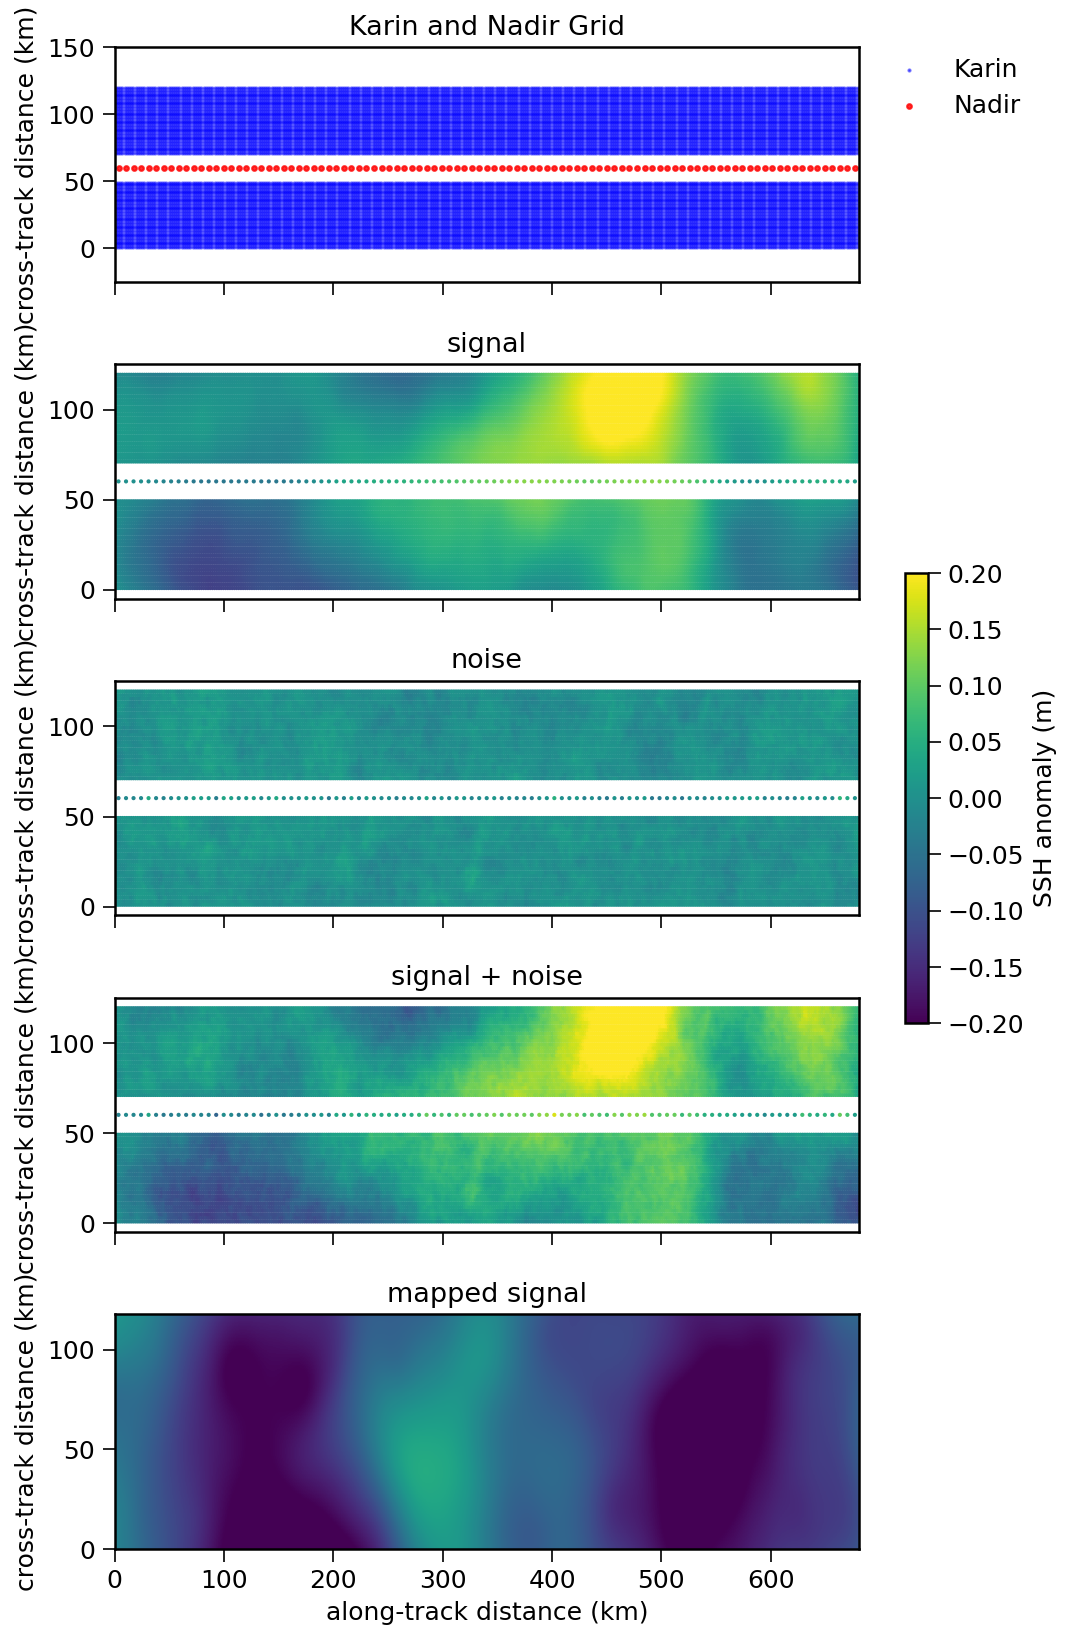

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

In [58]:
x_lim = (0, 1e-3 * nx * delta_kx)
y_lim = (0, 1e-3 * (ny + gap) * delta_ky)

fig, axes = plt.subplots(
    5, 1, figsize=(8, 13), sharex=True,
    gridspec_kw={'hspace': 0.35}
)

vmin = -0.2 
vmax = 0.2

axes[0].scatter(xk * 1e-3, yk * 1e-3, s=1,  c='blue', label='Karin', alpha=0.5)
axes[0].scatter(xn * 1e-3, yn * 1e-3, s=5, c='red',  label='Nadir', alpha=0.8)
axes[0].set_title('Karin and Nadir Grid')
axes[0].set_ylabel('cross-track distance (km)')
axes[0].set_xlim(*x_lim)
axes[0].set_ylim(-25, 150)
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

axes[1].scatter(1e-3 * xobs, 1e-3 * yobs, c=h,  s=1, vmin=vmin, vmax=vmax)
axes[1].set_title('signal')
axes[1].set_ylabel('cross-track distance (km)')

axes[2].scatter(1e-3 * xobs, 1e-3 * yobs, c=eta, s=1, vmin=vmin, vmax=vmax)
axes[2].set_title('noise')
axes[2].set_ylabel('cross-track distance (km)')

axes[3].scatter(1e-3 * xobs, 1e-3 * yobs, c=h + eta, s=1, vmin=vmin, vmax=vmax)
axes[3].set_title('signal + noise')
axes[3].set_ylabel('cross-track distance (km)')

im = axes[4].imshow(
    ht.reshape((nyt, nxt)), origin='lower',
    extent=np.array([0, nxt * delta_kx, 0, nyt * delta_ky]) * 1e-3,
    vmin=vmin, vmax=vmax, aspect='auto'
)
axes[4].set_title('mapped signal')
axes[4].set_xlabel('along-track distance (km)')
axes[4].set_ylabel('cross-track distance (km)')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, pad=0.05)
cbar.set_label('SSH anomaly (m)')

plt.tight_layout()
plt.show()
plt.gcf()


### Now we generate 20 synthetic obervations from our covariance functions and use these to reconstruct the spectrum of our original field

In [59]:
# Loop over 10 realizations and generate synthetic signals 
hs_list   = []
etas_list = []

for i in range(20):
    h, eta, _, _ = swot.generate_signal_and_noise(F, Fk, sigma, nx * ny, nn)
    hs_list.append(h)
    etas_list.append(eta)

# optiona lly convert to arrays (they’ll become ragged if shapes differ)
hs   = np.array(hs_list,   dtype=object)
etas = np.array(etas_list, dtype=object)

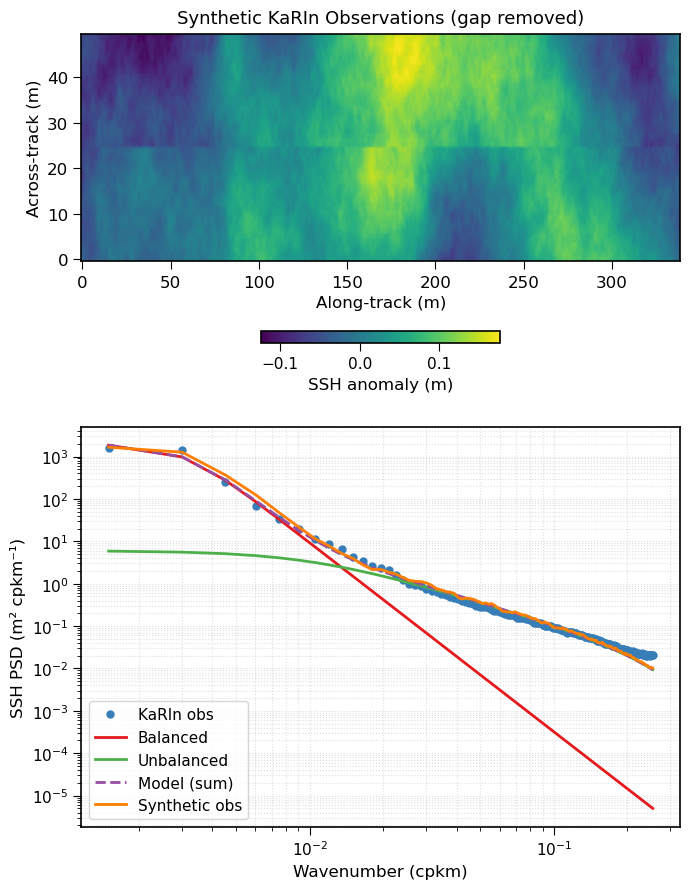

In [60]:
# Now we modify our generated field to get the karin part
h_k = hs[:, :nx*ny]
eta_k = etas[:, :nx*ny]
h_combined = h_k  + eta_k

h_syn = np.zeros((hs.shape[0], ny, nx))
for i in range(hs.shape[0]):
    h_syn[i, :, :] = h_combined[i, :].reshape(ny, nx)

def compute_gen_sample_mean(ht_map, x, y):
    if ht_map.shape[0] != len(y):
        ht_map = ht_map.T

    gen_ssha = xr.DataArray(ht_map, dims=['line', 'pixel'], coords={'line': y, 'pixel': x})
    n_lines = ht_map.shape[0]
    window_vals = np.sqrt(8/3) * np.sin(np.pi * np.arange(n_lines) / n_lines) ** 2
    window_x = xr.DataArray(window_vals, dims=['line'], coords={'line': gen_ssha['line']})
    gen_anom = gen_ssha - gen_ssha.mean(dim=['line','pixel'], skipna=True)
    pspec = xrft.power_spectrum(gen_anom * window_x, dim='line')
    pspec_av = 2* pspec.mean(dim='pixel')

    return pspec_av[int(n_lines/2):]

syn_sample_means = []
for i in range(h_syn.shape[0]):
    gen_sample_mean_synthetic = compute_gen_sample_mean(h_syn[i, :, :], karin.x_obs, karin.y_coord) # our generated signal + noise from above
    syn_sample_means.append(gen_sample_mean_synthetic)

syn_sample_means = np.array(syn_sample_means)
time_mean_synthetic = np.mean(syn_sample_means, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), dpi=100, gridspec_kw={'height_ratios': [0.7, 0.8]})

# ─── Top panel: synthetic‐obs image ───────────────────────────────
sc = ax1.imshow(h_syn[0, :, :], aspect='auto', origin='lower')
ax1.set_title('Synthetic KaRIn Observations (gap removed)', fontsize=13, pad=8)
ax1.set_ylabel('Across‐track (m)', fontsize=12)
ax1.set_xlabel('Along‐track (m)', fontsize=12)
cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', shrink=0.4, pad=0.2)
cbar.ax.tick_params(labelsize=11)
cbar.set_label('SSH anomaly (m)', fontsize=12)

# ─── Bottom panel: spectrum ───────────────────────────────────────
ax2.loglog(k_km[1:], karin_spec_sample_mean[1:], 'o', markersize=5, label='KaRIn obs')
ax2.loglog(k_km[1:], spbalanced, lw=2, label='Balanced')
ax2.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced')
ax2.loglog(k_km[1:], (spunbalanced[1:] + spbalanced), '--', lw=2, label='Model (sum)')
ax2.loglog(k_km[1:], time_mean_synthetic[1:], '-', lw=2, label='Synthetic obs')

ax2.set_xlabel('Wavenumber (cpkm)', fontsize=12)
ax2.set_ylabel('SSH PSD (m² cpkm⁻¹)', fontsize=12)
ax2.legend(loc='lower left', fontsize=11, frameon=True)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.grid(True, which='both', linestyle=':', alpha=0.4)

plt.tight_layout(h_pad=2)
plt.show()


## 5. Apply the models to the real SWOT SSH data 

In [61]:
from scipy.linalg import block_diag

index = 1 # time index 

mask_k = ~np.isnan(karin.ssha[index])
mask_n = ~np.isnan(nadir.ssh[index]) # N.B we are using SSH here because we aren't subtracting the time mean from the nadir

#  masks for karin and nadir
mask_k_flat = mask_k.T.flatten(order="C")             # transpose to match meshgrid order
mask_full   = np.concatenate((mask_k_flat, mask_n))   # len = nx*ny + nn

# observed ssha values
h_obs = np.concatenate((
    karin.ssha[index].T.flatten(order="C")[mask_k_flat],   # Karin
    nadir.ssh[index][mask_n]                               # Nadir
))

# covariance for observed points
C_obs = swot.build_covariance_matrix(c,  xobs, yobs)

# Karin noise block on observed pixels
Nk_obs  = nk(np.hypot(
                    xobs[:mask_k_flat.sum(), None] - xobs[:mask_k_flat.sum()],
                    yobs[:mask_k_flat.sum(), None] - yobs[:mask_k_flat.sum()]))

# Nadir noise block (white noise on diagonal)
Nn_obs  = sigma**2 * np.eye(mask_n.sum())

# assemble block-diagonal noise matrix
N_obs = block_diag(Nk_obs, Nn_obs)

# solve on the reduced system 
xt, yt, nxt, nyt = swot.make_target_grid(karin) # make our target grid with the gap filled
ht = swot.estimate_signal_on_target(c, xt, yt, xobs, yobs, C_obs, N_obs, h_obs)


Calculating covariance matrices...
Estimating signal on target points...
shape h: (17049,)
shape R: (20340, 17049)
Signal estimation time: 150.8319 seconds


#### Loop over all frames and save the data if we want it 

In [293]:
n_frames = ssha_anom_karin.shape[0]

for idx in range(n_frames):

    h_obs = np.concatenate([
        ssha_anom_karin[idx].T.ravel(order="C")[mask_k_flat],
        ssha_anom_nadir[idx][mask_n]
    ])
    
    ht = estimate_signal_on_target(
        c, xt, yt,
        xobs, yobs,
        C_obs, N_obs,
        h_obs
    )
    filename = f"./outputs/P{pass_number:03d}_C{shared_cycles[idx]:03d}_{idx:03d}.npy"
    np.save(filename, ht.reshape(nyt, nxt))
    print(f"Frame {idx:03d} → saved `{filename}`")

Estimating signal on target points...
shape h: (11366,)
shape R: (13560, 11366)
Signal estimation time: 65.5674 seconds
Frame 000 → saved `./output/P004_C476_000.npy`
Estimating signal on target points...
shape h: (11366,)
shape R: (13560, 11366)


KeyboardInterrupt: 

(60,)


/scratch/jskinner1/job_39963827/ipykernel_3617198/199736336.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


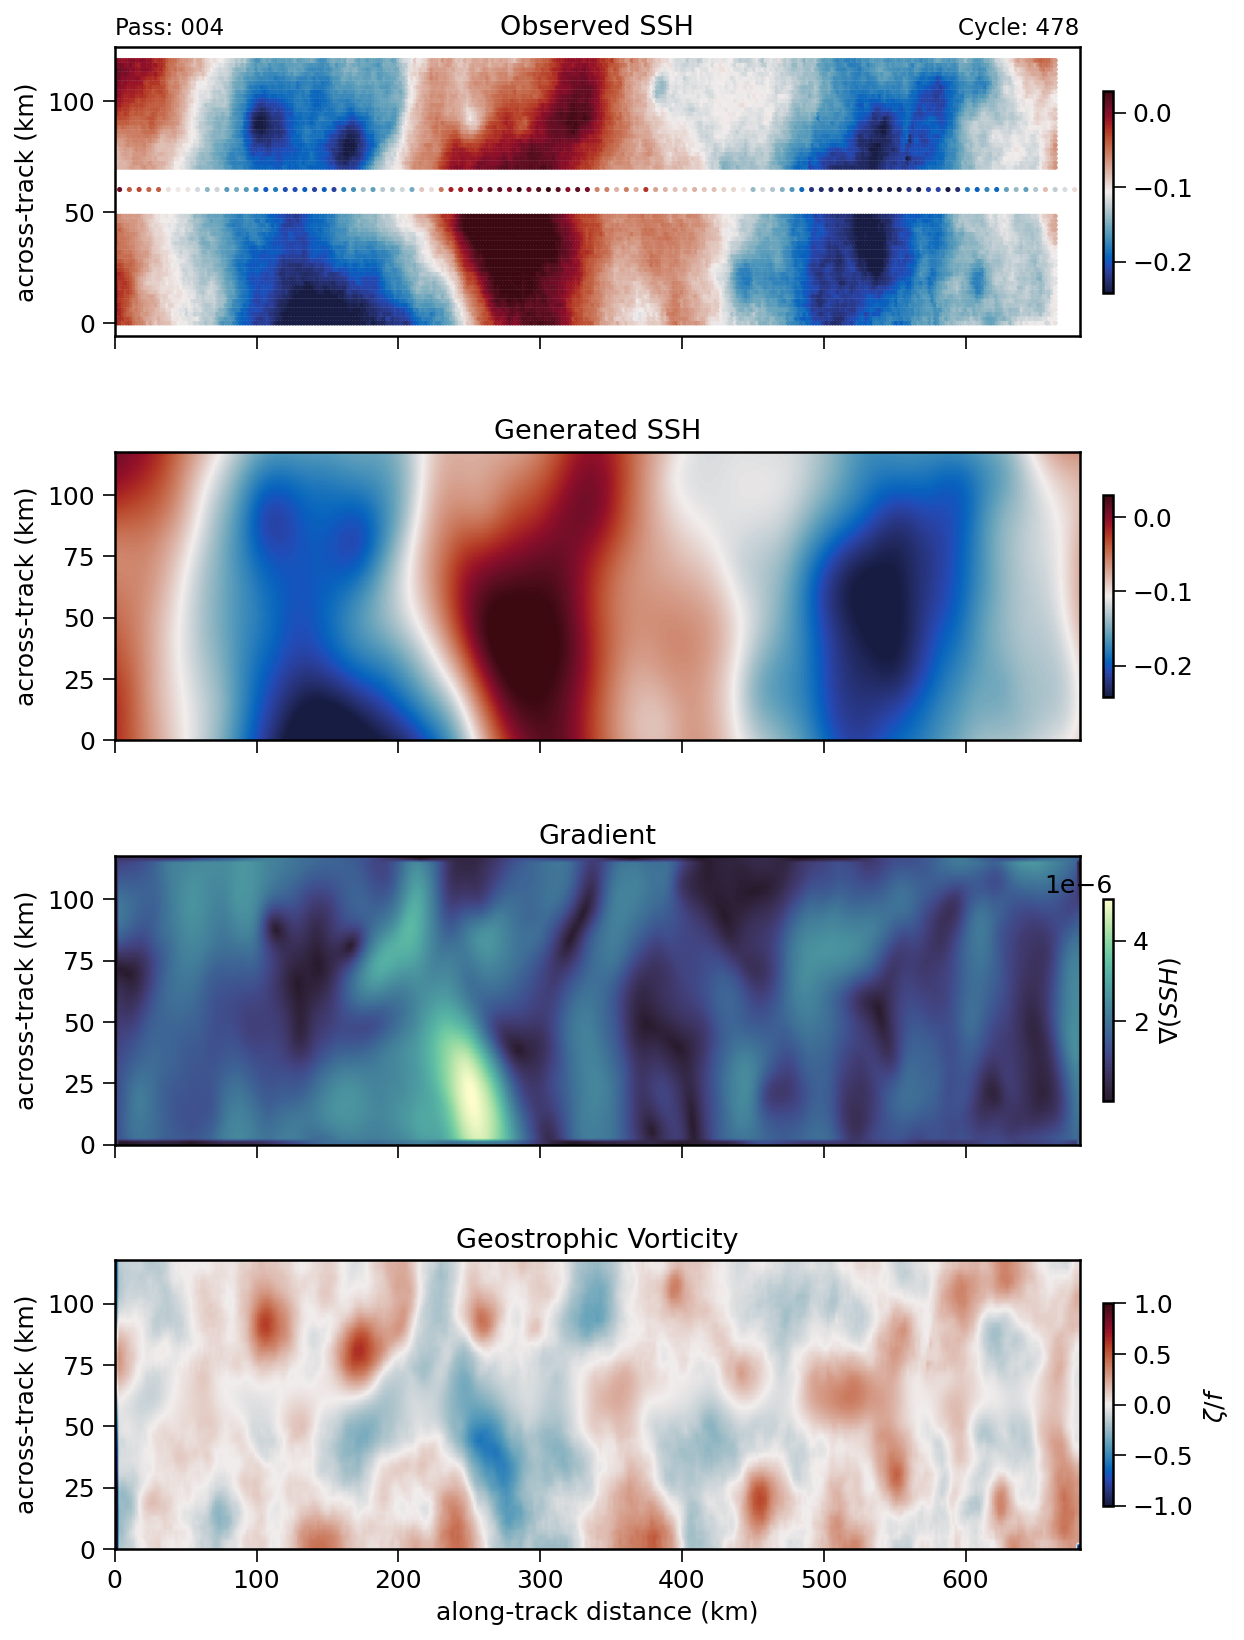

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# ── reshape the map and pick colour limits 
ht_map = ht.reshape(nyt, nxt)
vmin, vmax = np.nanpercentile(ht_map, [2, 98])   # robust limits

# ── build the figure
fig, axes = plt.subplots(4, 1, figsize=(10, 13), sharex=True,
                         gridspec_kw={"hspace": 0.4})

sc = axes[0].scatter(
    karin.y_grid * 1e-3, karin.x_grid * 1e-3,
    c=karin.ssha[index, :, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
sc = axes[0].scatter(
    xn * 1e-3, yn * 1e-3,
    c=nadir.ssh[index, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0].set_title("Observed SSH")
axes[0].set_title("Cycle: {}".format(shared_cycles[index]), fontsize=11, loc='right')
axes[0].set_title("Pass: {:03d}".format(pass_number), fontsize=11, loc='left')
#axes[0].set_xlabel("along-track (km)")
axes[0].set_ylabel("across-track (km)")
axes[0].set_aspect("auto")
fig.colorbar(sc, ax=axes[0], orientation='vertical', shrink=0.7, pad=0.02)

lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), karin.lat.shape[2])
print(lats.shape)
geo_vort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)


# 1. gridded estimate (imshow)
im0 = axes[1].imshow(
    ht_map,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax
)
axes[1].set_title("Generated SSH")
axes[1].set_ylabel("across-track (km)")
fig.colorbar(im0, ax=axes[1], orientation='vertical', shrink=0.7, pad=0.02)

im1 = axes[2].imshow(
    swot.compute_gradient(ht_map),
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.deep_r
)
axes[2].set_title("Gradient")
axes[2].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[2], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\nabla(SSH)$')

im1 = axes[3].imshow(
    geo_vort,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    vmin = -1, 
    vmax = 1,
    cmap=cmocean.cm.balance
)
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[3], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\zeta / f$')

# shared colour-bar
plt.tight_layout()
plt.show()


### PDF of Cyclonicity

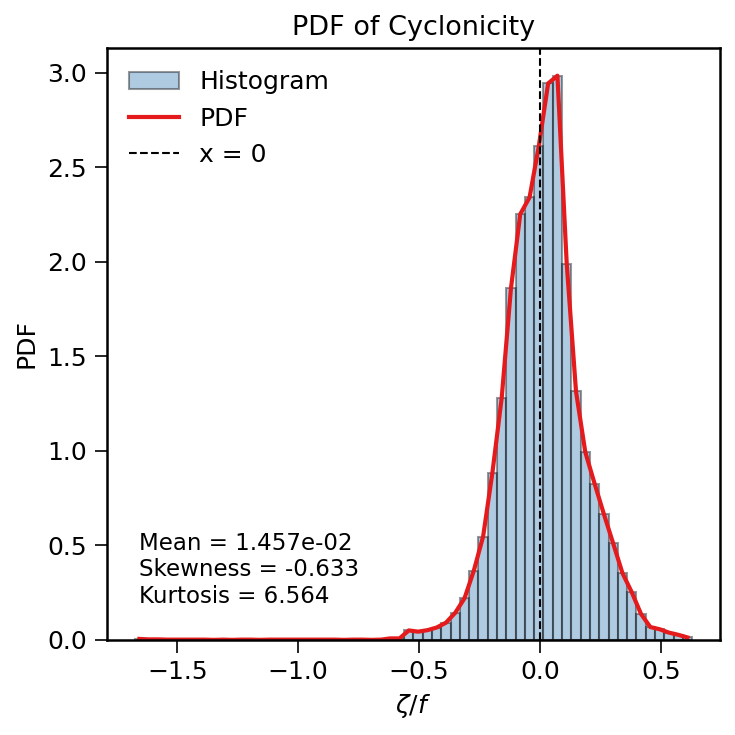

In [66]:
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis
from matplotlib.offsetbox import AnchoredText

# Make a plot of the skewness and kurtosis of the vorticity
vals = geo_vort.ravel()
vals = vals[~np.isnan(vals)]

mean_vort = np.mean(vals)
skew_vort = stats.skew(vals, bias=False)
kurt = kurtosis(vals, fisher=True, bias=False)

# 4. Build histogram (density) and get bin‐centers
n_bins = 60
hist, edges = np.histogram(vals, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

# 5. Plot
plt.figure(figsize=(5, 5))

# filled histogram
plt.hist(vals, bins=n_bins, density=True,
         alpha=0.4, edgecolor='k', label='Histogram')

# line through the PDF
plt.plot(centers, hist, '-', lw=2, label='PDF')

# annotate mean & skewness
txt = (
    f"Mean = {mean_vort:.3e}\n"
    f"Skewness = {skew_vort:.3f}\n"
    f"Kurtosis = {kurt:.3f}"
)
at = AnchoredText(txt, loc='lower left', prop=dict(size=11), frameon=True, pad=0.6, borderpad=0.8)
at.patch.set(alpha=0.7, facecolor='white', edgecolor='none')
plt.gca().add_artist(at)

plt.axvline(0, color='k', linestyle='--', linewidth=1, label='x = 0')


# labels & legend
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 6. Compare interpolation with Nadir to without Nadir 

In [ ]:
index = 1 

# observed ssha values
h_karin = karin.ssha[index].T.flatten(order="C")[mask_k_flat]

# Karin noise and signal on observed pixels
N_obs  = nk(np.hypot(
                    xk[:mask_k_flat.sum(), None] - xk[:mask_k_flat.sum()],
                    yk[:mask_k_flat.sum(), None] - yk[:mask_k_flat.sum()]))

C_obs = swot.build_covariance_matrix(c,  xk, yk)

ht_karonly = swot.estimate_signal_on_target(c, xt, yt, xk, yk, C_obs, N_obs, h_karin)
ht_karonly_map = ht_karonly.reshape(nyt, nxt)

Calculating covariance matrices...
Estimating signal on target points...


#Check this part because the lap difference doesnt match what visual inspection of the differences suggests

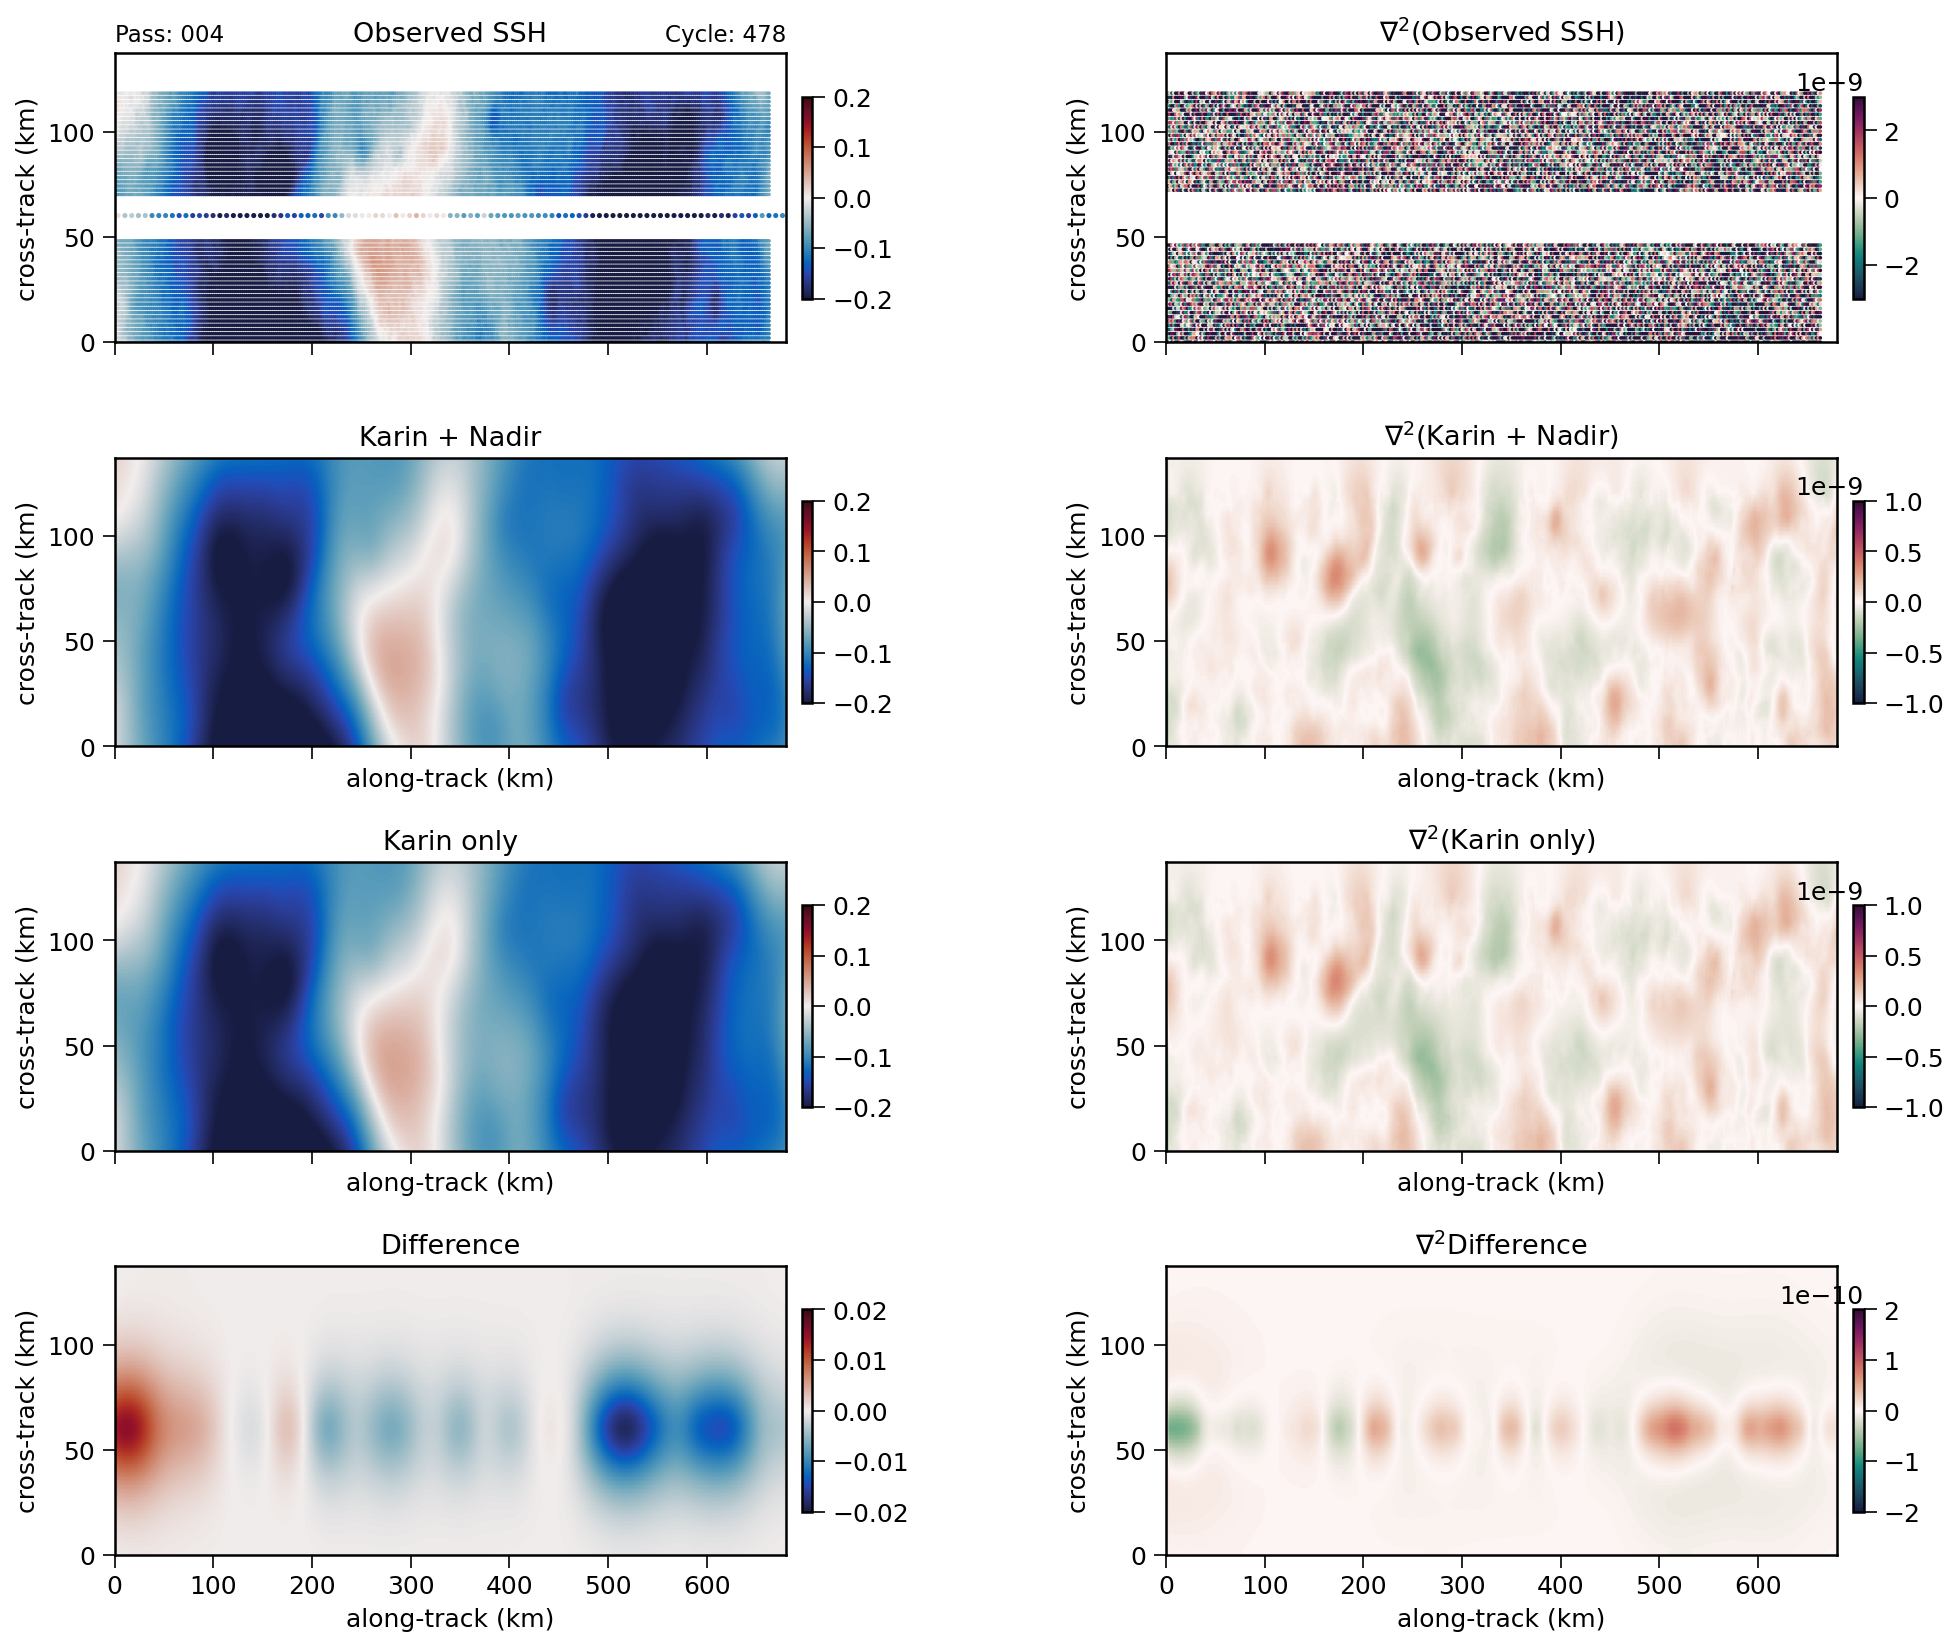

In [46]:
fields = [
    ("Observed SSH", lambda: (karin.ssha[index], karin.y_grid, karin.x_grid)),
    ("Karin + Nadir", lambda: (ht_map, None, None)),
    ("Karin only", lambda: (ht_karonly_map, None, None)),
    ("Difference", lambda: (ht_map - ht_karonly_map, None, None)),
]

# ── define your per-panel vmin/vmax pairs ──
orig_vlims = [
    (-0.2, 0.2),       # for Observed SSH
    (-0.2, 0.2),       # for Generated SSH
    (-0.2, 0.2),       # for 2 km Gaussian
    (-0.02, 0.02),     # for Gen − 2 km Gauss
]
lap_vlims = [
    (-3e-9, 3e-9),   # for ∇²(Observed SSH)
    (-1e-9, 1e-9),   # for ∇²(Generated SSH)
    (-1e-9, 1e-9),   # for ∇²(2 km Gaussian)
    (-2e-10, 2e-10),   # for ∇²(Gen − 2 km Gauss)
]

fig, axes = plt.subplots(4, 2, figsize=(16, 13),
                         sharex='col', sharey='col',
                         gridspec_kw={"wspace":0.3, "hspace":0.4})

for i, (title, getter) in enumerate(fields):
    field, kyt, kxt = getter()

    # left: original
    ax = axes[i, 0]
    vmin_o, vmax_o = orig_vlims[i]
    if kyt is not None:
        m = ax.scatter(kyt*1e-3, kxt*1e-3, c=field, s=3,
                       cmap=cmocean.cm.balance,
                       vmin=vmin_o, vmax=vmax_o,
                       edgecolor="none")
        sc = ax.scatter(xn * 1e-3, yn * 1e-3, c=nadir.ssh[index, :], 
                        s=6, cmap=cmocean.cm.balance, vmin=vmin_o, vmax=vmax_o, 
                        edgecolor="none")
    else:
        m = ax.imshow(field,
                      origin="lower",
                      extent=(0, nxt*karin.dx*1e-3,
                              0, nyt*karin.dy*1e-3),
                      aspect="auto",
                      cmap=cmocean.cm.balance,
                      vmin=vmin_o, vmax=vmax_o)
    ax.set_title(title)
    if i == 0:
        ax.set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
        ax.set_title(f"Pass: {pass_number:03d}",       fontsize=11, loc='left')
    if i > 0:
        ax.set_xlabel("along-track (km)")
    ax.set_ylabel("cross-track (km)")
    fig.colorbar(m, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)

    # right: Laplacian (but for the last row do diff of Laplacians)
    ax2 = axes[i, 1]
    vmin_l, vmax_l = lap_vlims[i]
    if i == len(fields) - 1:
        # final panel: difference of the individual laplacians
        lap = (swot.compute_laplacian(ht_map)
             - swot.compute_laplacian(ht_karonly_map))
        title2 = r"$\nabla^2 {\rm Difference}$"
    else:
        lap = swot.compute_laplacian(field)
        title2 = r"$\nabla^2$(" + title + ")"

    if kyt is not None:
        m2 = ax2.scatter(kyt*1e-3, kxt*1e-3, c=lap, s=3,
                         cmap=cmocean.cm.curl,
                         vmin=vmin_l, vmax=vmax_l,
                         edgecolor="none")
    else:
        m2 = ax2.imshow(lap,
                        origin="lower",
                        extent=(0, nxt*karin.dx*1e-3,
                                0, nyt*karin.dy*1e-3),
                        aspect="auto",
                        cmap=cmocean.cm.curl,
                        vmin=vmin_l, vmax=vmax_l)
    ax2.set_title(title2)
    if i > 0:
        ax2.set_xlabel("along-track (km)")
    ax2.set_ylabel("cross-track (km)")
    fig.colorbar(m2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)



In [53]:
# Spectra of nadir vs no nadir 

# y_coord  = dy_karin * np.arange(track_length)            # m along track
# x_coord  = dx_karin * np.arange(total_width)             # m across track

gen_sample_mean = compute_gen_sample_mean(ht_map, karin.x_coord, karin.y_coord) # here the x y is our track dims from above not xobs yobs
gen_sample_mean_karonly = compute_gen_sample_mean(ht_karonly_map, x, y)

# plot the weighted fit
plt.figure(figsize=(5.5,5), dpi=120)
plt.loglog(k_km[1:], spectrum_sample_mean[1:],'o', label = 'SSHA data')
plt.loglog(k_km[1:], spbalanced,label = r'Balanced:$\sigma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[0:2]))
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced:$\sigma$=%5.3f, $\gamma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[2:5]))
plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.loglog(k_km[1:], gen_sample_mean[1:],'-', label = 'Karin + Nadir')
plt.loglog(k_km[1:], gen_sample_mean_karonly[1:],'--b', label = 'Karin only')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
#plt.xlim(1e-3, 3e-1)
plt.title('Weighted fit karin data')

ValueError: conflicting sizes for dimension 'pixel': length 70 on the data but length 60 on coordinate 'pixel'

In [55]:
print(ht_map.shape)
print(karin.ssha.shape)

(70, 339)
(97, 339, 60)
